DOGE

In [77]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/DataBA/DOGE.csv')  # Thay thế đường dẫn này bằng đường dẫn của bạn
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [79]:
# Sử dụng giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [80]:
# Tạo tập dữ liệu với look_back
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 90  # Chúng ta sẽ sử dụng look_back là 90 cho các mô hình 90, 60, và 30 ngày
X, Y = create_dataset(scaled_prices, look_back)

In [81]:
# Chia tập dữ liệu thành train và test
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [82]:

# Tạo và huấn luyện mô hình MLP
# Tạo mô hình MLP
model = Sequential()
model.add(Dense(64, input_dim=look_back, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
107/107 [==============================] - 1s 2ms/step - loss: 0.0149
Epoch 2/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 3/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 4/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 5/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 6/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 7/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 8/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 9/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 10/50
107/107 [==============================] - 0s 2ms/step - loss: 8.6272e-04
Epoch 11/50
107/107 [==============================] - 0s 2ms/step - loss: 8.4642e-04
Epoch 12/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 13/50
107/1

In [83]:
# Dự đoán trên tập test
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

6/6 [==============================] - 0s 2ms/step


In [84]:
# Tính toán các chỉ số RMSE, MAPE, và MASE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mape = mean_absolute_percentage_error(Y_test, Y_pred)

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(np.diff(y_train)))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors) / d

mase_score = mase(Y_test, Y_pred, Y_train)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MASE: {mase_score}')


RMSE: 125.2697223853172
MAPE: 0.030838402917060397
MASE: 9707.01511143295


In [85]:
def predict_future(model, data, look_back, days):
    future_data = data[-look_back:].reshape(1, -1)
    predictions = []
    for _ in range(days):
        prediction = model.predict(future_data)
        predictions.append(prediction[0][0])
        future_data = np.append(future_data[:, 1:], prediction, axis=1)
    return np.array(predictions).reshape(-1, 1)

lst_output_90 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 90))
lst_output_60 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 60))
lst_output_30 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 30))


1/1 [==============================] - 0s 36ms/step


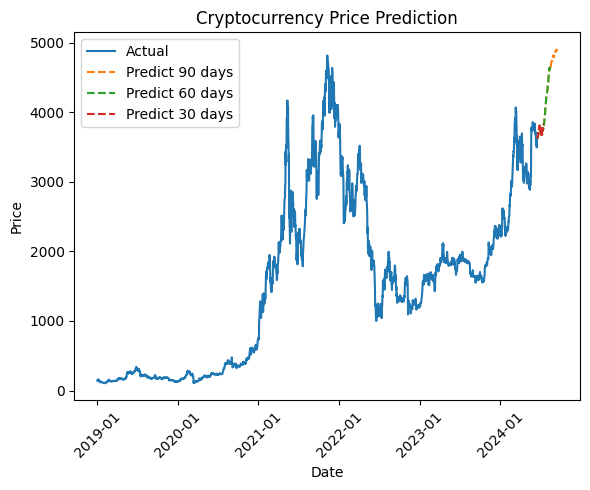

In [86]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Generate future dates for predictions
last_date = data.index[-1]
predict_data_index_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot the data
plt.figure(figsize=(6, 5))

# Plot actual prices
plt.plot(data.index, scaler.inverse_transform(scaled_prices), label='Actual')

# Plot predictions
plt.plot(predict_data_index_90, lst_output_90, label='Predict 90 days', linestyle='--')
plt.plot(predict_data_index_60, lst_output_60, label='Predict 60 days', linestyle='--')
plt.plot(predict_data_index_30, lst_output_30, label='Predict 30 days', linestyle='--')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Cryptocurrency Price Prediction')
plt.legend()
plt.tight_layout()
plt.show()


BTC

In [87]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/DataBA/BTC.csv')  # Thay thế đường dẫn này bằng đường dẫn của bạn
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [89]:
# Sử dụng giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [90]:
# Tạo tập dữ liệu với look_back
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 90  # Chúng ta sẽ sử dụng look_back là 90 cho các mô hình 90, 60, và 30 ngày
X, Y = create_dataset(scaled_prices, look_back)

In [91]:
# Chia tập dữ liệu thành train và test
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [92]:
# Tạo và huấn luyện mô hình MLP
# Tạo mô hình MLP
model = Sequential()
model.add(Dense(64, input_dim=look_back, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
107/107 [==============================] - 1s 2ms/step - loss: 0.0151
Epoch 2/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 3/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 4/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 5/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 7/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 9/50
107/107 [==============================] - 0s 2ms/step - loss: 9.5436e-04
Epoch 10/50
107/107 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 11/50
107/107 [==============================] - 0s 2ms/step - loss: 8.9410e-04
Epoch 12/50
107/107 [==============================] - 0s 2ms/step - loss: 9.0453e-04
Epoch 13/50
1

In [93]:
# Dự đoán trên tập test
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

6/6 [==============================] - 0s 4ms/step


In [94]:
# Tính toán các chỉ số RMSE, MAPE, và MASE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mape = mean_absolute_percentage_error(Y_test, Y_pred)

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(np.diff(y_train)))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors) / d

mase_score = mase(Y_test, Y_pred, Y_train)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MASE: {mase_score}')


RMSE: 2001.3033152676203
MAPE: 0.024834744557283944
MASE: 161308.50366257696


In [95]:
def predict_future(model, data, look_back, days):
    future_data = data[-look_back:].reshape(1, -1)
    predictions = []
    for _ in range(days):
        prediction = model.predict(future_data)
        predictions.append(prediction[0][0])
        future_data = np.append(future_data[:, 1:], prediction, axis=1)
    return np.array(predictions).reshape(-1, 1)

lst_output_90 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 90))
lst_output_60 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 60))
lst_output_30 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 30))


1/1 [==============================] - 0s 46ms/step


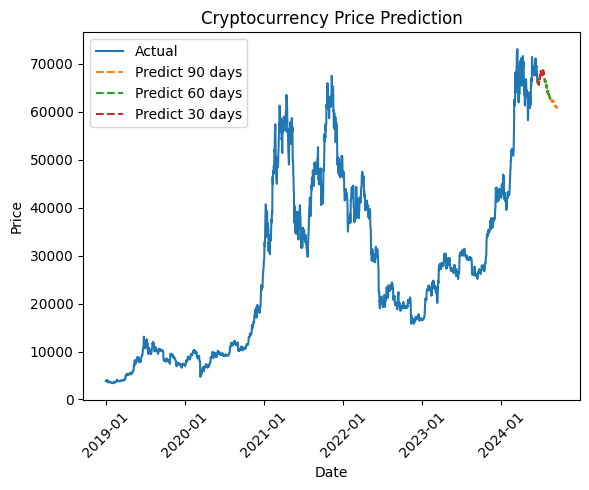

In [96]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Generate future dates for predictions
last_date = data.index[-1]
predict_data_index_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot the data
plt.figure(figsize=(6, 5))

# Plot actual prices
plt.plot(data.index, scaler.inverse_transform(scaled_prices), label='Actual')

# Plot predictions
plt.plot(predict_data_index_90, lst_output_90, label='Predict 90 days', linestyle='--')
plt.plot(predict_data_index_60, lst_output_60, label='Predict 60 days', linestyle='--')
plt.plot(predict_data_index_30, lst_output_30, label='Predict 30 days', linestyle='--')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Cryptocurrency Price Prediction')
plt.legend()
plt.tight_layout()
plt.show()


ETH

In [97]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/DataBA/ETH.csv')  # Thay thế đường dẫn này bằng đường dẫn của bạn
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [99]:
# Sử dụng giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

In [100]:
# Tạo tập dữ liệu với look_back
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 90  # Chúng ta sẽ sử dụng look_back là 90 cho các mô hình 90, 60, và 30 ngày
X, Y = create_dataset(scaled_prices, look_back)

In [101]:
# Chia tập dữ liệu thành train và test
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [102]:
# Tạo và huấn luyện mô hình MLP
# Tạo mô hình MLP
model = Sequential()
model.add(Dense(64, input_dim=look_back, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
107/107 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 2/50
107/107 [==============================] - 0s 2ms/step - loss: 9.9548e-04
Epoch 3/50
107/107 [==============================] - 0s 2ms/step - loss: 8.0795e-04
Epoch 4/50
107/107 [==============================] - 0s 2ms/step - loss: 6.0657e-04
Epoch 5/50
107/107 [==============================] - 0s 2ms/step - loss: 6.0674e-04
Epoch 6/50
107/107 [==============================] - 0s 2ms/step - loss: 4.9202e-04
Epoch 7/50
107/107 [==============================] - 0s 2ms/step - loss: 5.6087e-04
Epoch 8/50
107/107 [==============================] - 0s 2ms/step - loss: 5.2487e-04
Epoch 9/50
107/107 [==============================] - 0s 2ms/step - loss: 4.5274e-04
Epoch 10/50
107/107 [==============================] - 0s 2ms/step - loss: 4.7152e-04
Epoch 11/50
107/107 [==============================] - 0s 2ms/step - loss: 5.5749e-04
Epoch 12/50
107/107 [==============================] - 0s 2ms/step 

In [103]:
# Dự đoán trên tập test
Y_pred = model.predict(X_test)
Y_pred = scaler.inverse_transform(Y_pred.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

6/6 [==============================] - 0s 3ms/step


In [104]:
# Tính toán các chỉ số RMSE, MAPE, và MASE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mape = mean_absolute_percentage_error(Y_test, Y_pred)

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(np.diff(y_train)))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors) / d

mase_score = mase(Y_test, Y_pred, Y_train)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'MASE: {mase_score}')

RMSE: 0.01091113071436693
MAPE: 0.05142843929932197
MASE: 1.2469505058327994


In [105]:
def predict_future(model, data, look_back, days):
    future_data = data[-look_back:].reshape(1, -1)
    predictions = []
    for _ in range(days):
        prediction = model.predict(future_data)
        predictions.append(prediction[0][0])
        future_data = np.append(future_data[:, 1:], prediction, axis=1)
    return np.array(predictions).reshape(-1, 1)

lst_output_90 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 90))
lst_output_60 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 60))
lst_output_30 = scaler.inverse_transform(predict_future(model, scaled_prices, look_back, 30))


1/1 [==============================] - 0s 20ms/step


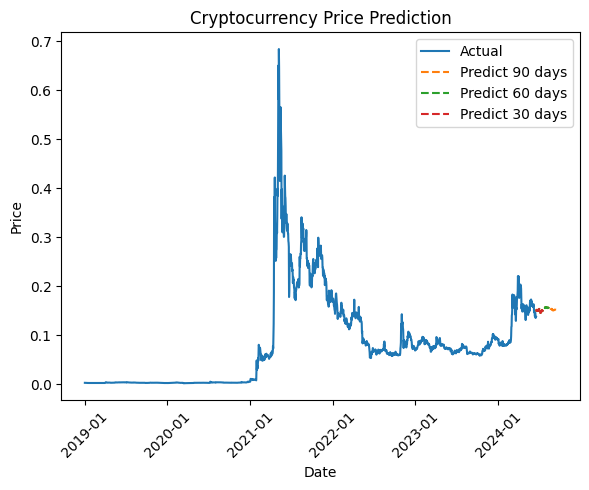

In [106]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Generate future dates for predictions
last_date = data.index[-1]
predict_data_index_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Plot the data
plt.figure(figsize=(6, 5))

# Plot actual prices
plt.plot(data.index, scaler.inverse_transform(scaled_prices), label='Actual')

# Plot predictions
plt.plot(predict_data_index_90, lst_output_90, label='Predict 90 days', linestyle='--')
plt.plot(predict_data_index_60, lst_output_60, label='Predict 60 days', linestyle='--')
plt.plot(predict_data_index_30, lst_output_30, label='Predict 30 days', linestyle='--')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Cryptocurrency Price Prediction')
plt.legend()
plt.tight_layout()
plt.show()
